In [1]:
import numpy as np
import random
import pandas as pd
import warnings

# Suppress the SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

#set random seed for consistency in testing
np.random.seed(0)
    
## ============== Helper Functions ==============
# Simulate two dice being rolled and their resulting rolls being summed
def DICE():
    x1 = random.randint(1,6)
    x2 = random.randint(1,6)
    return x1 + x2


# Insert dataframe of event history
def generate_statistic(events:pd.DataFrame) -> float:
    event = events[~events['departure_time'].isna()]
    event['waiting time'] = event['departure_time'] - event['start_time'] - event['service_time']
    
    #=========Mean===========
    total_waiting_time = sum(event['waiting time'])
    average_waiting_time = total_waiting_time/len(event)
    #=========Minimum===========
    minimum_waiting_time = np.min(event['waiting time'])
    #=========Variance===========
    variance_waiting_time = np.var(event['waiting time'])#((total_waiting_time - average_waiting_time)**2)/len(event)
    #=========Standard Deviation===========
    standard_deviation_waiting_time = np.sqrt(variance_waiting_time)
    #=========Confidence Interval===========
    # 95% confidence interval
    confidence_interval_waiting_time = [average_waiting_time - 1.96*(standard_deviation_waiting_time/(len(event)**(1/2))),average_waiting_time + 1.96*(standard_deviation_waiting_time/(len(event)**(1/2)))]
   
    return average_waiting_time, minimum_waiting_time,variance_waiting_time, standard_deviation_waiting_time, confidence_interval_waiting_time



## ============== Event class ==============         
class callEvent:
    def __init__(self, time, event_type, product_type, start_time, service_time=None, departure_time=None):
        self.time = time
        self.type = event_type
        self.product_type = product_type
        self.start_time = start_time
        self.service_time = service_time
        self.departure_time = departure_time
        
    def __str__(self):
        return f'callEvent(time: {self.time}, type: {self.type}, product_type: {self.product_type}, service_time: {self.service_time}, departure_time: {self.departure_time})'
    
def generate_arrival(time):
    type_roll = DICE()
    product_type = 'car_stereo' if type_roll <= 4 else 'other' # car-stereo/other
    return callEvent(time=time, event_type='arrival', product_type=product_type, start_time=time)


## ============== Call Center Class ==============
# Class specifics:
# - time is measured in minutes
# - customers refer to callers

# Random variables:
#1. Time between arrivals of calls at the center = (DICE * 0.333) minutes, done in wrapper.
#2. The delay at the IVR unit = (DICE * 0.3) minutes.
#3. The delay for car-stereo call processing = (DICE * 2) minutes.
#4. The delay for other-product call processing= (DICE) minutes. 

class callCenter():# a call center simulation class
    def __init__(self, CALL_MAX=10):
        self.car_stereo_queue = []
        self.other_queue = []
        
        self.cs_status ='idle'
        self.o_status = 'idle'
        
        self.clock = 0
        self.event_calendar = pd.DataFrame(columns=['time','type','product_type','start_time','service_time','departure_time'])
        self.event_history = pd.DataFrame(columns=['time','type','product_type','start_time','service_time','departure_time'])
        
        self.call_max = CALL_MAX # maximum queue length for call arrivals to splitter

        
    def add_event(self, event):
        # Add a new event to the event calendar 
        new_event = pd.DataFrame({'time': [event.time], 'type': [event.type], 'product_type': [event.product_type],
                                  'start_time': [event.start_time],'service_time': [event.service_time],
                                  'departure_time': [event.departure_time]})
        self.event_calendar = pd.concat([self.event_calendar, new_event], ignore_index=True)

        
    def log(self, event):
        new_event = pd.DataFrame({'time': [event.time], 'type': [event.type], 'product_type': [event.product_type],
                                  'start_time': [event.start_time],'service_time': [event.service_time],
                                  'departure_time': [event.departure_time]})
        self.event_history = pd.concat([self.event_history, new_event], ignore_index=True)
        
        
    def run_simulation(self, end_time): # example: if time is greater than 5*60 = 300 minutes, then call center is closed
        while (self.event_calendar.empty == False) and (self.clock < end_time):
            # Order events by time and pop top
            self.event_calendar = self.event_calendar.sort_values(by="time")
            curr_event = callEvent(time=self.event_calendar.iloc[0].time, event_type=self.event_calendar.iloc[0].type, 
                                   product_type=self.event_calendar.iloc[0].product_type,
                                   start_time=self.event_calendar.iloc[0].start_time,
                                   service_time=self.event_calendar.iloc[0].service_time, 
                                   departure_time=self.event_calendar.iloc[0].departure_time)
            self.event_calendar = self.event_calendar.iloc[1:]
            
            self.clock = curr_event.time
            self.log(curr_event)
            self.handle_event(curr_event)
            
            
    def handle_event(self, event):
        if event.type == 'arrival':
            # If the parallel switching queue is too long, the caller hangs up
            if len(self.car_stereo_queue) + len(self.other_queue) > self.call_max:
                busy_event = callEvent(time=self.clock, event_type='busy', product_type=event.product_type,
                                       start_time=event.start_time, service_time=0, departure_time=self.clock)
                self.add_event(busy_event) # This doesn't need to be processed in event type as it is just logged
                return

            # If the IVR queue is empty put it through to the next series after delay
            # Add event to IVR queue
            IVR_delay = DICE() * 0.3
            IVR_event = callEvent(time=self.clock+IVR_delay, event_type='IVR', product_type=event.product_type, 
                                  start_time=event.start_time, service_time=IVR_delay, departure_time=None)
            # Queue keeps track of current IVR queue, the IVR event makes sure it gets taken care of by the event handler
            self.add_event(IVR_event)
            
        elif event.type == 'IVR':
            
            # Split the IVR queue into car-stereo and others queue separation
            if event.product_type == 'car_stereo':
                if self.cs_status == 'idle':
                    self.cs_status = 'busy'
                    
                    # Add event to car-stereo queue
                    car_stereo_delay = DICE() * 2
                    self.schedule_service(event, 'car_stereo_queue', car_stereo_delay)
                else:
                    self.car_stereo_queue.append(event)
                    
            if event.product_type == 'other':
                if self.o_status == 'idle':
                    self.o_status = 'busy'
                    # Add event to other queue
                    other_delay = DICE()
                    self.schedule_service(event, 'other_queue', other_delay)
                else:
                    self.other_queue.append(event)
                    
        ## Handle car stereo queue and operation
        elif event.type == 'car_stereo_queue':
            self.cs_status = 'idle'
            self.service_completion(event, self.car_stereo_queue, DICE() * 2)
        
        # Handle other queue and operation
        elif event.type == 'other_queue':
            self.o_status = 'idle'
            self.service_completion(event, self.other_queue, DICE())
            
            
    def schedule_service(self, event, queue_type, delay):
        # Function to schedule a service event based on the delay
        new_event = callEvent(time=self.clock + delay, event_type=queue_type, 
                              product_type=event.product_type, start_time=event.start_time, 
                              service_time=event.service_time + delay, departure_time=None)
        self.add_event(new_event)

    # Queue handling/status checking and departure creation
    def service_completion(self, event, queue, delay):
        # print(f'{event.product_type}: {len(queue)}')
        if len(queue) > 0:
            next_event = queue.pop(0)
            if event.product_type == 'car_stereo':
                self.cs_status = 'busy'
                self.schedule_service(next_event, 'car_stereo_queue', delay)
            else:
                self.o_status = 'busy'
                self.schedule_service(next_event, 'other_queue', delay)
                
        departure_event = callEvent(time=self.clock, event_type='departure', product_type=event.product_type, 
                                    start_time=event.start_time, service_time=event.service_time, 
                                    departure_time=self.clock)
        self.log(departure_event)    
            

In [9]:
# ==== Main ====
np.random.seed(0)
end_time = 300

bh_list = []
event_history_list = []
time = 0
df = pd.DataFrame(columns=['iteration', 'waiting percentage'])
for i in range(30):
    currCALL_MAX = 10 + i*2
    if i % 5 == 0:
        print(f"\tround {i}")
    cc = callCenter(currCALL_MAX)
    while time < end_time:
        cc.add_event(generate_arrival(time))
        time += DICE() * 0.333
        
    time = 0
    cc.run_simulation(end_time)
    #=========Analysis===========
    event_history_list.append(cc.event_history)
    new_row = {'iteration': int(i+1),
               'waiting percentage':len(cc.event_history[~cc.event_history['departure_time'].isna()]['departure_time'])/len(cc.event_history)*100}
    
    #export df to csv
    eh = cc.event_history[~cc.event_history['departure_time'].isna()]
    eh['waiting time'] = eh.apply(lambda x: x['departure_time'] - x['start_time'] - x['service_time'], axis=1)
    print('For standard call center structure.')
    print('Percentage of callers waiting over 1 minute:',np.sum(eh['waiting time'] > 1)/len(eh) * 100,'%')
    bh = len(cc.event_history[cc.event_history['type'] == 'busy'])/len(cc.event_history[cc.event_history['type'] == 'arrival']) * 100
    print('Percentage of busy hang ups:',bh,'%')

    bh_list.append((currCALL_MAX,bh))
    df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)

	round 0
For standard call center structure.
Percentage of callers waiting over 1 minute: 39.66942148760331 %
Percentage of busy hang ups: 52.27272727272727 %
For standard call center structure.
Percentage of callers waiting over 1 minute: 36.666666666666664 %
Percentage of busy hang ups: 52.98507462686567 %
For standard call center structure.
Percentage of callers waiting over 1 minute: 44.95412844036697 %
Percentage of busy hang ups: 43.54838709677419 %
For standard call center structure.
Percentage of callers waiting over 1 minute: 38.392857142857146 %
Percentage of busy hang ups: 48.06201550387597 %
For standard call center structure.
Percentage of callers waiting over 1 minute: 53.535353535353536 %
Percentage of busy hang ups: 34.710743801652896 %
	round 5
For standard call center structure.
Percentage of callers waiting over 1 minute: 48.67256637168141 %
Percentage of busy hang ups: 41.35338345864661 %
For standard call center structure.
Percentage of callers waiting over 1 minut

Text(0.5, 1.0, 'Percentage of callers that hit busy signal\n in standard one car stereo queue and one others queue')

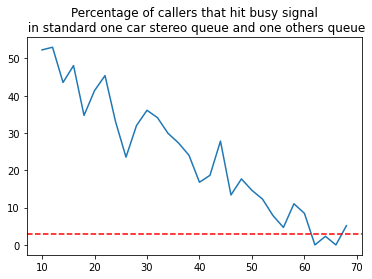

In [19]:
import matplotlib.pyplot as plt
bh_df = pd.DataFrame(bh_list)
plt.plot(bh_df[0],bh_df[1])

# Draw a dashed line at y=3
plt.axhline(y=3, color='red', linestyle='--', label='Dashed Line at y=3')
plt.title('Percentage of callers that hit busy signal\n in standard one car stereo queue and one others queue')


In [13]:
bh_df

,0,1
0,10,52.272727
1,12,52.985075
2,14,43.548387
3,16,48.062016
4,18,34.710744
5,20,41.353383
6,22,45.384615
7,24,33.076923
8,26,23.529412
9,28,32.000000
